In [ ]:
!pip install -q torch torchvision torchaudio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)


Device in use: cuda


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


device(type='cuda')

In [ ]:
vgg11 = models.vgg11(weights='IMAGENET1K_V1')
vgg11.classifier[6] = nn.Linear(4096, 100)
vgg11 = vgg11.to(device)

In [ ]:
from tqdm import tqdm

from tqdm import tqdm
import torch, time

def evaluate(model, dataloader, device='cuda', dtype=None):
    model.eval()
    model.to(device)

    if dtype is None:
        try:
            first_param = next(model.parameters())
            dtype = first_param.dtype
        except StopIteration:
            dtype = torch.float32

    total, correct = 0, 0
    total_time, total_size = 0.0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.to(dtype)

            torch.cuda.synchronize()
            start = time.time()
            outputs = model(inputs)
            torch.cuda.synchronize()
            end = time.time()

            total_time += end - start
            total_size += inputs.size(0)

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    latency = total_time / total_size
    return acc



def model_size_mb(model):
    model_cpu = copy.deepcopy(model).cpu()
    b = io.BytesIO()
    torch.save(model_cpu.state_dict(), b)
    size_mb = b.getbuffer().nbytes / (1024*1024)
    return size_mb



def measure_latency(model, device, dtype=torch.float32, input_shape=(1,3,224,224), iters=50):
    model.eval()
    dummy = torch.randn(*input_shape, device=device, dtype=dtype)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy)  # warmup
    times = []
    with torch.no_grad():
        for _ in range(iters):
            torch.cuda.synchronize()
            t0 = time.time()
            if dtype in [torch.float16, torch.bfloat16]:
                with torch.autocast(device_type=device.type, dtype=dtype):
                    _ = model(dummy)
            else:
                _ = model(dummy)
            torch.cuda.synchronize()
            t1 = time.time()
            times.append(t1 - t0)
    return float(np.mean(times)) * 1000.0

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    history = {"epoch":[], "val_acc":[]}
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Train epoch {epoch+1}/{epochs}", leave=False)
        running = 0.0
        for x,y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            running += loss.item()
            pbar.set_postfix(loss=loss.item())
        val_acc = evaluate(model, test_loader)
        history["epoch"].append(epoch+1)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1} val_acc: {val_acc:.2f}%")
    return model, history



In [ ]:
model_fp32 = vgg11
print("Training baseline VGG-11 (FP32)...")
model_fp32, hist = train_model(model_fp32, trainloader, testloader, epochs=5, lr=1e-2)
baseline_acc = evaluate(model_fp32, testloader,device=device)
print("Baseline FP32 acc:", baseline_acc)
import copy, io, time

print("Baseline size (MB):", f"{model_size_mb(model_fp32):.2f}")
print("Average Latency ms:", f"{measure_latency(model_fp32, device=device):.2f}")


Training baseline VGG-11 (FP32)...


Epoch 1 val_acc: 85.22%


Epoch 2 val_acc: 85.55%


Epoch 3 val_acc: 87.10%


Epoch 4 val_acc: 86.95%


Epoch 5 val_acc: 86.10%


Baseline FP32 acc: 86.1
Baseline size (MB): 492.77
Average Latency ms: 5.79


In [ ]:
from torchao.quantization import quantize_, Int8WeightOnlyConfig

uniform_model = copy.deepcopy(model_fp32)
uniform_model.eval()
quantize_(uniform_model, Int8WeightOnlyConfig(group_size=32))

int8_acc = evaluate(uniform_model, testloader)
print(f"Uniform INT8 Accuracy: {int8_acc:.2f}%")




Uniform INT8 Accuracy: 86.10%


In [ ]:
mixed = copy.deepcopy(model_fp32).to(device).eval()
FIRST_NAME = "features.0"
LAST_NAME  = "classifier.6"

for name, module in mixed.named_modules():
    if not isinstance(module, (nn.Conv2d, nn.Linear)):
        continue
    if name in (FIRST_NAME, LAST_NAME):
        continue
    try:
        quantize_(module, Int8WeightOnlyConfig(group_size=32))
    except Exception:
        pass

mod_dict = dict(mixed.named_modules())
first_conv = mod_dict[FIRST_NAME]
last_lin   = mod_dict[LAST_NAME]

conv_w, conv_b = first_conv.weight.detach().cpu(), first_conv.bias.detach().cpu()
lin_w, lin_b   = last_lin.weight.detach().cpu(), last_lin.bias.detach().cpu()
conv_hparams   = (first_conv.stride, first_conv.padding, first_conv.dilation, first_conv.groups)

class RobustSimpleMixed(nn.Module):
    def __init__(self, base, conv_w, conv_b, conv_hparams, lin_w, lin_b):
        super().__init__()
        self.base = base
        self.conv_w, self.conv_b, self.conv_hparams = conv_w, conv_b, conv_hparams
        self.lin_w, self.lin_b = lin_w, lin_b

        self.features_post = nn.Sequential(*list(self.base.features.children())[1:])
        self.avgpool = self.base.avgpool
        self.classifier_pre = nn.Sequential(*list(self.base.classifier.children())[:-1])

    def forward(self, x):
        dev = x.device
        x16 = x.half()
        w16, b16 = self.conv_w.half().to(dev), self.conv_b.half().to(dev) if self.conv_b is not None else None
        out = F.conv2d(x16, w16, b16, *self.conv_hparams)
        out = out.float()

        out = self.features_post(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier_pre(out)

        out16 = out.half()
        lw16, lb16 = self.lin_w.half().to(dev), self.lin_b.half().to(dev) if self.lin_b is not None else None
        out = F.linear(out16, lw16, lb16)
        return out.float()

simple_mix_model = RobustSimpleMixed(mixed, conv_w, conv_b, conv_hparams, lin_w, lin_b).to(device).eval()

print("Evaluating Simple Mixed-Precision model...")
acc = evaluate(simple_mix_model, testloader, device)
print(f"Accuracy: {acc:.2f}%")


Evaluating Simple Mixed-Precision model...


Accuracy: 86.11%


In [ ]:
import torch.nn as nn

def estimate_size_bytes_from_map(model, precision_map):

    total_bits = 0
    for name, module in model.named_modules():
        if not isinstance(module, (nn.Conv2d, nn.Linear)):
            continue
        numel = sum(p.numel() for p in module.parameters() if p is not None)
        bits = precision_map.get(name, 32)
        total_bits += numel * bits
    return total_bits // 8

In [ ]:
def compute_activation_variances(model, loader, device, max_batches=20):
    model = model.to(device).eval()
    variances = {}
    hooks = []

    def make_hook(name):
        def hook(module, inp, out):
            if isinstance(out, torch.Tensor):
                variances.setdefault(name, []).append(float(out.detach().var().item()))
        return hook

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            hooks.append(module.register_forward_hook(make_hook(name)))

    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            x = x.to(device)
            _ = model(x)
            if i + 1 >= max_batches:
                break

    for h in hooks:
        h.remove()

    avg_vars = {k: np.mean(v) for k, v in variances.items() if len(v) > 0}
    return avg_vars


print(" Calibrating activation variances (running ~20 batches)...")
act_vars = compute_activation_variances(model_fp32, trainloader, device, max_batches=20)
sorted_vars = sorted(act_vars.items(), key=lambda kv: kv[1], reverse=True)
print(f"Measured {len(sorted_vars)} layers.")
print("Top 8 layers by variance:")
for n, v in sorted_vars[:8]:
    print(f"  {n:40s}  {v:.4e}")



layer_names = [n for n, _ in sorted_vars]
N = len(layer_names)
top_k = max(1, int(0.20 * N))

precision_map = {}
for i, name in enumerate(layer_names):
    precision_map[name] = 32 if i < top_k else 8

precision_map['features.0'] = 32
precision_map['classifier.6'] = 32

print("Precision counts:", Counter(precision_map.values()))



def make_state_quantized_copy(model_fp32, precision_map):
    m = copy.deepcopy(model_fp32)
    sd = model_fp32.state_dict()
    new_sd = {}

    for k, v in sd.items():
        if not k.endswith(".weight"):
            new_sd[k] = v.cpu()
            continue

        mod_name = k[:-7]
        bits = precision_map.get(mod_name, 8)
        wt = v.detach().cpu().float().numpy()

        if bits == 32:
            new_sd[k] = torch.from_numpy(wt).to(dtype=torch.float32)
        elif bits == 8:
            maxval = np.abs(wt).max()
            if maxval == 0:
                new_sd[k] = torch.from_numpy(wt).to(dtype=torch.float32)
            else:
                scale = maxval / 127.0
                q = np.round(wt / scale).clip(-127, 127)
                deq = (q * scale).astype(np.float32)
                new_sd[k] = torch.from_numpy(deq)
        else:
            new_sd[k] = torch.from_numpy(wt).to(dtype=torch.float32)

    m.load_state_dict(new_sd)
    return m


adaptive_model = make_state_quantized_copy(model_fp32, precision_map).to(device).eval()
all32_map = {name: 32 for name, module in model_fp32.named_modules()
             if isinstance(module, (nn.Conv2d, nn.Linear))}
full_precision_map = {name: precision_map.get(name, 8) for name in all32_map.keys()}


baseline_size_mb = model_size_mb(model_fp32)
uniform8_size_mb = model_size_mb(uniform_model)
simple_size_mb = model_size_mb(simple_mix_model)
adaptive_size_mb = estimate_size_bytes_from_map(model_fp32, full_precision_map) / 1e6


configs = {
    "FP32_baseline": model_fp32,
    "Uniform_INT8": uniform_model,
    "Simple_mixed": simple_mix_model,
    "Adaptive_mixed": adaptive_model
}

results = {}

for name, m in configs.items():
    print(f"\n Evaluating {name} ...")
    acc = evaluate(m, testloader, device)
    lat = measure_latency(m, device, input_shape=(1,3,224,224), iters=30)
    if name=='Adaptive_mixed':
      size=estimate_size_bytes_from_map(model_fp32, full_precision_map) / 1e6
    else:
      size = model_size_mb(m)
    results[name] = {'acc': acc, 'latency_ms': lat, 'size_mb': size}
    print(f" → {name}: acc={acc:.2f}% | latency={lat:.2f} ms/sample | size={size:.2f} MB")


print("\n==================== SUMMARY ====================")
print(f"{'Config':20s} | {'Acc (%)':>8s} | {'Latency (ms)':>13s} | {'Size (MB)':>9s}")
print("-" * 56)
for k, v in results.items():
    print(f"{k:20s} | {v['acc']:8.2f} | {v['latency_ms']:13.2f} | {v['size_mb']:9.2f}")
print("=================================================")

 Calibrating activation variances (running ~20 batches)...
Measured 11 layers.
Top 8 layers by variance:
  classifier.6                              7.2352e+00
  features.3                                3.4610e+00
  features.6                                2.3921e+00
  features.8                                1.6640e+00
  features.11                               9.2527e-01
  features.0                                7.1518e-01
  classifier.0                              6.7094e-01
  features.13                               3.7969e-01
Precision counts: Counter({8: 8, 32: 3})

 Evaluating FP32_baseline ...


 → FP32_baseline: acc=86.10% | latency=5.53 ms/sample | size=492.77 MB

 Evaluating Uniform_INT8 ...


 → Uniform_INT8: acc=86.10% | latency=20.44 ms/sample | size=192.50 MB

 Evaluating Simple_mixed ...


 → Simple_mixed: acc=86.11% | latency=20.79 ms/sample | size=193.53 MB

 Evaluating Adaptive_mixed ...


 → Adaptive_mixed: acc=86.11% | latency=5.51 ms/sample | size=130.63 MB

==================== SUMMARY ====================
Config               |  Acc (%) |  Latency (ms) | Size (MB)
--------------------------------------------------------
FP32_baseline        |    86.10 |          5.53 |    492.77
Uniform_INT8         |    86.10 |         20.44 |    192.50
Simple_mixed         |    86.11 |         20.79 |    193.53
Adaptive_mixed       |    86.11 |          5.51 |    130.63


In [ ]:
model_fp32.avgpool = nn.AdaptiveAvgPool2d((7, 7))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

activation_dict = {}

def get_activation(name):
    def hook(model, input, output):
        activation_dict[name] = output.detach().cpu().flatten().numpy()
    return hook

model_fp32.features[0].register_forward_hook(get_activation('conv1'))
model_fp32.features[3].register_forward_hook(get_activation('conv2'))
model_fp32.features[6].register_forward_hook(get_activation('conv3'))
model_fp32.features[13].register_forward_hook(get_activation('conv4'))
model_fp32.classifier[0].register_forward_hook(get_activation('fc1'))


In [ ]:
model_fp32.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(testloader):
        images = images.to(device)
        _ = model_fp32(images)
        if i == 10:
            break


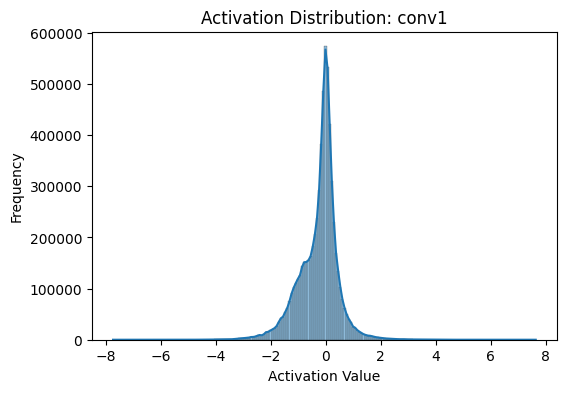

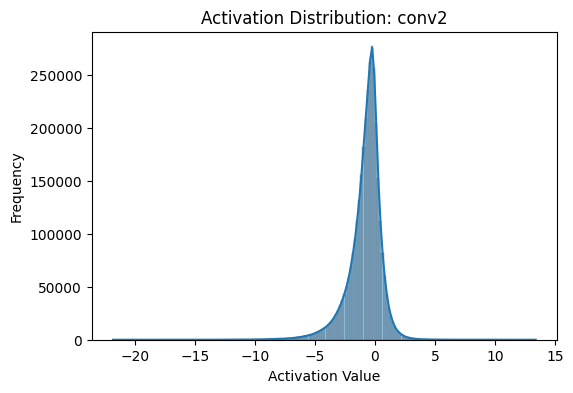

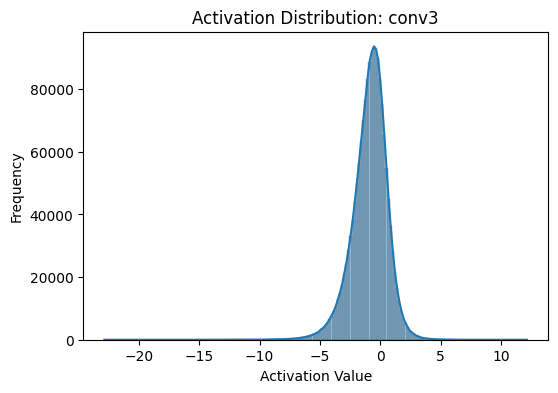

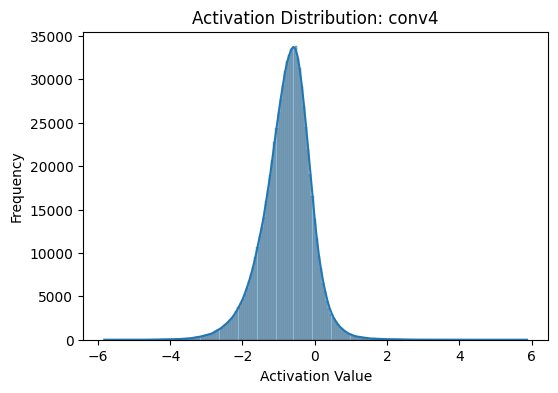

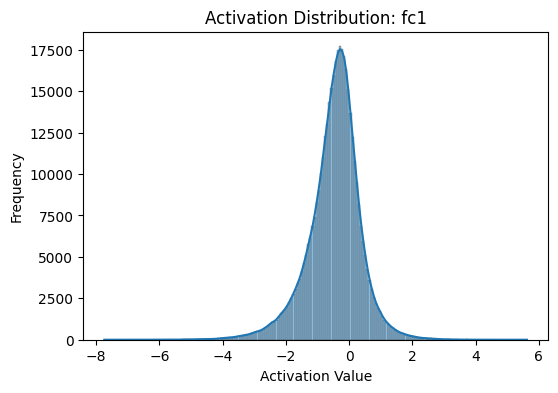

In [ ]:
for name, act in activation_dict.items():
    plt.figure(figsize=(6,4))
    sns.histplot(act, bins=200, kde=True)
    plt.title(f'Activation Distribution: {name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
def uniform_quantize(x, bits=8, clip=None):
    if clip is not None:
        x = torch.clamp(x, -clip, clip)
    qmin, qmax = -2**(bits-1), 2**(bits-1)-1
    scale = x.abs().max() / qmax
    x_q = torch.round(x / scale).clamp(qmin, qmax)
    return x_q * scale

def percentile_clip(x, percentile=99.9):
    return np.percentile(x.abs().cpu().numpy(), percentile)



In [ ]:
class QuantizedVGG(nn.Module):
    def __init__(self, model, bits=8, clip_percentile=None):
        super().__init__()
        self.model = model
        self.bits = bits
        self.clip_percentile = clip_percentile

    def forward(self, x):
        for name, layer in self.model.features._modules.items():
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                if self.clip_percentile is not None:
                    clip = percentile_clip(x, self.clip_percentile)
                    x = uniform_quantize(x, self.bits, clip)
                else:
                    x = uniform_quantize(x, self.bits)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.classifier(x)
        return x



In [ ]:
quant_model_no_clip = QuantizedVGG(model_fp32, bits=8, clip_percentile=None)
quant_model_clip = QuantizedVGG(model_fp32, bits=8, clip_percentile=99.9)


In [ ]:
acc_int8_no_clip = evaluate(quant_model_no_clip, testloader, device=device)
acc_int8_clip = evaluate(quant_model_clip, testloader, device=device)

print("FP32 accuracy:", f"{baseline_acc:.2f}%")
print("INT8 no clip:", f"{acc_int8_no_clip:.2f}%")
print("INT8 clipped (99.9%):", f"{acc_int8_clip:.2f}%")


FP32 accuracy: 86.10%
INT8 no clip: 86.08%
INT8 clipped (99.9%): 86.28%


In [ ]:
print(f"FP32 accuracy: {baseline_acc:.2f}%")
print(f"INT8 no clip: {acc_int8_no_clip:.2f}%")
print(f"INT8 clipped (99.9%): {acc_int8_clip:.2f}%")

print("No-clip size (MB):", f"{model_size_mb(quant_model_no_clip):.2f}")
print("Clip size (MB):", f"{model_size_mb(quant_model_clip):.2f}")
print("Latency no clip (ms):", f"{measure_latency(quant_model_no_clip, device=device):.2f}")
print("Latency clip (ms):", f"{measure_latency(quant_model_clip, device=device):.2f}")

FP32 accuracy: 86.10%
INT8 no clip: 86.08%
INT8 clipped (99.9%): 86.28%
No-clip size (MB): 492.77
Clip size (MB): 492.77
Latency no clip (ms): 23.02
Latency clip (ms): 125.18


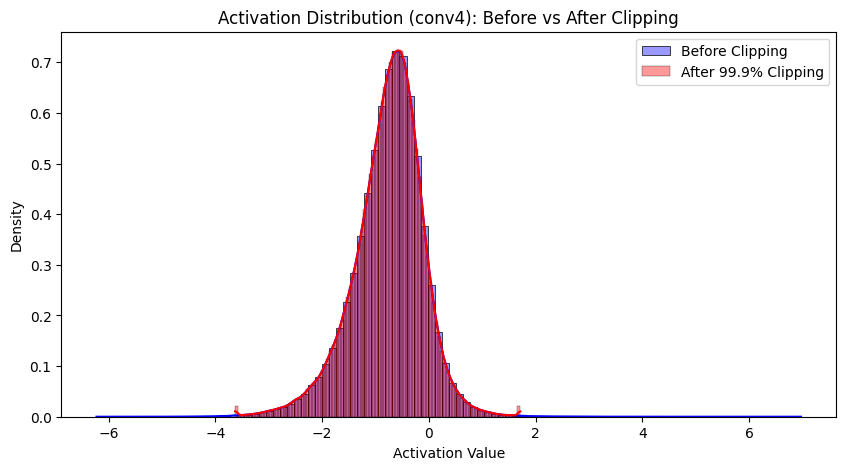

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x_sample, _ = next(iter(testloader))
x_sample = x_sample.to(device)

with torch.no_grad():
    act = model_fp32.features[:14](x_sample)
    act_np = act.flatten().cpu().numpy()

p_low, p_high = np.percentile(act_np, [0.1, 99.9])
act_clipped = torch.clamp(act, p_low, p_high)
act_clipped_np = act_clipped.flatten().cpu().numpy()

plt.figure(figsize=(10, 5))
sns.histplot(act_np, bins=100, kde=True, color="blue", label="Before Clipping", stat="density", alpha=0.4)
sns.histplot(act_clipped_np, bins=100, kde=True, color="red", label="After 99.9% Clipping", stat="density", alpha=0.4)
plt.legend()
plt.title("Activation Distribution (conv4): Before vs After Clipping")
plt.xlabel("Activation Value")
plt.ylabel("Density")
plt.show()



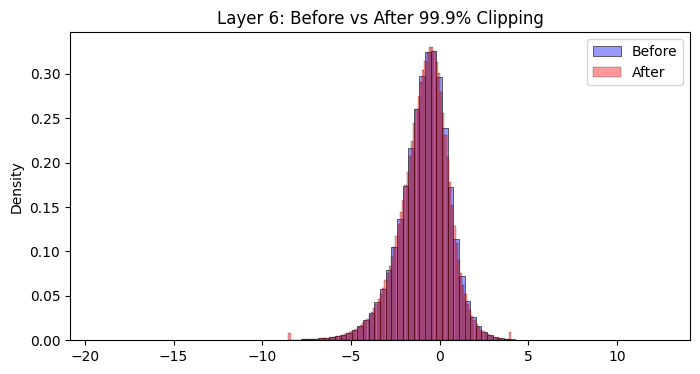

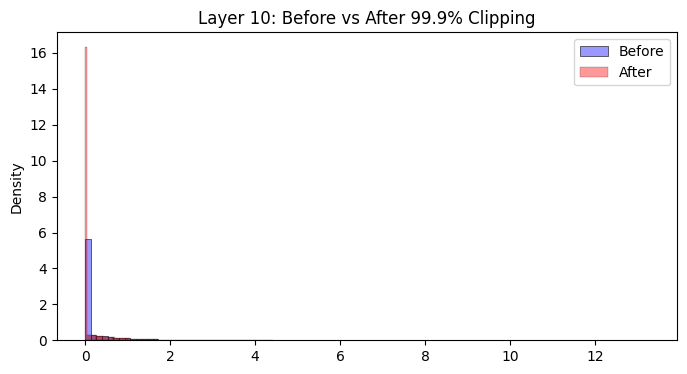

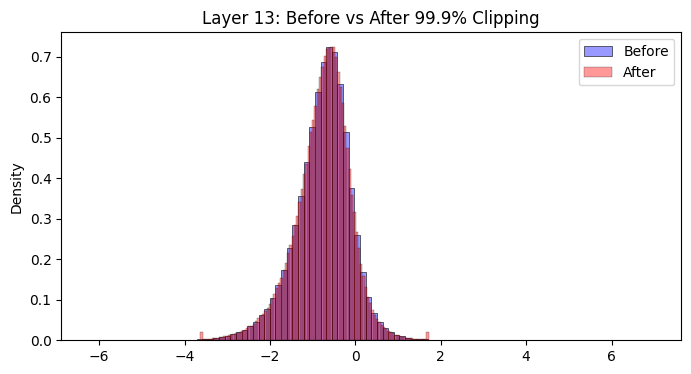

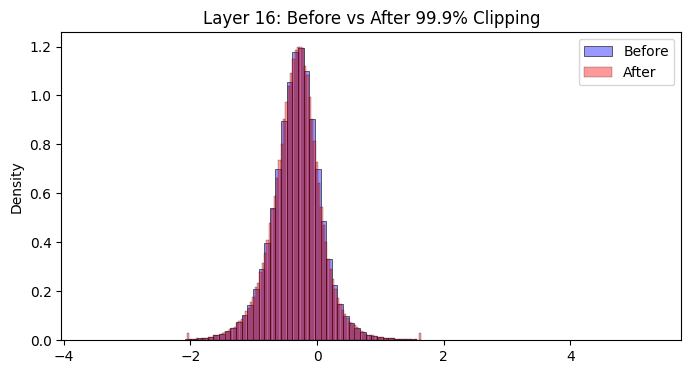

In [ ]:
layer_indices = [6, 10, 13, 16]
for i in layer_indices:
    with torch.no_grad():
        act = model_fp32.features[:i+1](x_sample)
        act_np = act.flatten().cpu().numpy()
        p_low, p_high = np.percentile(act_np, [0.1, 99.9])
        act_clipped_np = np.clip(act_np, p_low, p_high)

    plt.figure(figsize=(8,4))
    sns.histplot(act_np, bins=100, color="blue", label="Before", stat="density", alpha=0.4)
    sns.histplot(act_clipped_np, bins=100, color="red", label="After", stat="density", alpha=0.4)
    plt.legend()
    plt.title(f"Layer {i}: Before vs After 99.9% Clipping")
    plt.show()


In [ ]:
def record_metrics(model, name, device, dtype=torch.float32):
    try:
        acc = evaluate(model, testloader, device=device, dtype=dtype)
        size = model_size_mb(model)
        lat = measure_latency(model, device=device, dtype=dtype)
        return {'acc': acc, 'size_mb': size, 'lat_ms': lat}
    except Exception as e:
        print(f"{name} evaluation error:", e)
        return {'acc': None, 'size_mb': None, 'lat_ms': None}

In [ ]:
from torch.ao.quantization import QConfig, MinMaxObserver, PerChannelMinMaxObserver

qconfig = QConfig(
    activation=MinMaxObserver.with_args(quant_min=0, quant_max=255),
    weight=PerChannelMinMaxObserver.with_args(quant_min=-127, quant_max=127)
)

from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, prepare_qat_fx
from torch.ao.quantization import get_default_qconfig, get_default_qat_qconfig
from torch.ao.quantization.qconfig_mapping import QConfigMapping

In [ ]:
ptq_results = {}

def record_metrics(model, name, device, dtype=torch.float32):
    try:
        acc = evaluate(model, testloader, device=device, dtype=dtype)
        size = model_size_mb(model)
        lat = measure_latency(model, device=device, dtype=dtype)
        return {'acc': acc, 'size_mb': size, 'lat_ms': lat}
    except Exception as e:
        print(f"{name} evaluation error:", e)
        return {'acc': None, 'size_mb': None, 'lat_ms': None}

try:
    m_fp16 = copy.deepcopy(model_fp32).half().to(device)
    ptq_results['fp16'] = record_metrics(m_fp16, "FP16", device, dtype=torch.float16)
except Exception as e:
    ptq_results['fp16'] = None
    print("FP16 evaluation error:", e)

try:
    m_bf16 = copy.deepcopy(model_fp32).to(torch.bfloat16).to(device)
    ptq_results['bf16'] = record_metrics(m_bf16, "BF16", device, dtype=torch.bfloat16)
except Exception as e:
    ptq_results['bf16'] = None
    print("BF16 evaluation error:", e)

try:
    qconfig = get_default_qconfig("fbgemm")
    qconfig_map = QConfigMapping().set_global(qconfig)
    example_inputs = torch.randn(1,3,224,224)

    model_cpu = copy.deepcopy(model_fp32).eval().cpu()
    prepared = prepare_fx(model_cpu, qconfig_map, example_inputs)

    with torch.no_grad():
        for i, (x, _) in enumerate(trainloader):
            prepared(x.cpu())
            if i >= 50:
                break

    model_int8 = convert_fx(prepared)
    model_int8.eval()

    ptq_results['int8'] = record_metrics(model_int8, "INT8", device=torch.device('cpu'))
except Exception as e:
    ptq_results['int8'] = {'acc': None, 'size_mb': None, 'lat_ms': None}
    print("INT8 PTQ error:", e)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import copy
import time


def quantize_weight_per_channel_4bit(w, clip_percentile=99.9):
    w_q = torch.zeros_like(w)
    for c in range(w.shape[0]):
        w_c = w[c]
        w_np = w_c.detach().cpu().numpy().flatten()
        p_low, p_high = np.percentile(w_np, [100 - clip_percentile, clip_percentile])
        w_c = torch.clamp(w_c, p_low, p_high)
        qmin, qmax = -8, 7
        w_min, w_max = w_c.min(), w_c.max()
        scale = (w_max - w_min) / (qmax - qmin)
        if scale < 1e-8:
            w_q[c] = w_c
        else:
            w_int = torch.clamp(torch.round(w_c / scale), qmin, qmax)
            w_q[c] = w_int * scale
    return w_q

def quantize_activation_4bit(x):
    x_min, x_max = x.min(), x.max()
    if (x_max - x_min) < 1e-8:
        return x
    scale = (x_max - x_min) / 15.0
    x_q = torch.clamp(torch.round(x / scale), -8, 7)
    return x_q * scale

class QuantizedWrapperINT4(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        for name, layer in self.model.features._modules.items():
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                x = quantize_activation_4bit(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)

        for name, layer in self.model.classifier._modules.items():
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                x = quantize_activation_4bit(x)
        return x

def simulate_int4_quantization_improved(model_fp32, device):
    model_int4 = copy.deepcopy(model_fp32).to(device)
    model_int4.eval()

    with torch.no_grad():
        for name, param in model_int4.named_parameters():
            if param.ndim >= 2:
                param.copy_(quantize_weight_per_channel_4bit(param))
            else:
                param.copy_(param)

    model_int4 = QuantizedWrapperINT4(model_int4)
    return model_int4


In [ ]:


try:
    model_int4_improved = simulate_int4_quantization_improved(model_fp32, device)
    acc_int4_improved = evaluate(model_int4_improved, testloader, device=device)
    size_int4_improved = model_size_mb(model_int4_improved, bits_per_param=4)
    lat_int4_improved = measure_latency(model_int4_improved, device=device)

    ptq_results['INT4'] = {
        'acc': acc_int4_improved,
        'size_mb': size_int4_improved,
        'lat_ms': lat_int4_improved
    }

except Exception as e:
    ptq_results['int4_improved'] = {'acc': None, 'size_mb': None, 'lat_ms': None}
    print("INT4 improved simulation error:", e)


In [ ]:
print("\n=== PTQ Summary ===")
for k, v in ptq_results.items():
    if isinstance(v, dict):
        acc = v.get('acc', 0) or 0
        size = v.get('size_mb', 0) or 0
        lat = v.get('lat_ms', 0) or 0
    else:
        acc, size, lat = v or 0, 0, 0

    print(f"{k.upper():<8} | Acc: {acc:.2f} | Size: {size:.2f} MB | Latency: {lat:.2f} ms")


=== PTQ Summary ===
FP16     | Acc: 86.11 | Size: 246.39 MB | Latency: 12.75 ms
BF16     | Acc: 86.11 | Size: 246.39 MB | Latency: 12.25 ms
INT8     | Acc: 85.78 | Size: 123.41 MB | Latency: 122.15 ms
INT4     | Acc: 82.87 | Size: 61.60 MB | Latency: 24.18 ms


In [ ]:
import torch
import torch.nn as nn
import copy

try:
    from torch.ao.quantization.qconfig import get_default_qat_qconfig
    from torch.ao.quantization.fx import prepare_qat_fx, convert_fx
    from torch.ao.quantization import QConfigMapping
except ImportError:
    from torch.quantization import get_default_qat_qconfig, prepare_qat, convert
    prepare_qat_fx = prepare_qat
    convert_fx = convert
    class QConfigMapping:
        @staticmethod
        def set_global(qconfig):
            return qconfig


In [ ]:
def qat_train(model, trainloader, device, epochs=3, lr=1e-4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"QAT Epoch [{epoch+1}/{epochs}]", leave=False, ncols=100)

        for x, y in progress_bar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / len(trainloader)
        print(f"QAT Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

    return model

In [ ]:
def record_metrics(model, name, device, dtype=torch.float32, bits=None):
    try:
        acc = evaluate(model, testloader, device=device, dtype=dtype)
        size = model_size_mb(model, bits=bits)  # ✅ use bit precision
        lat = measure_latency(model, device=device, dtype=dtype)
        print(f"{name} | Acc: {acc:.2f}% | Size: {size:.2f} MB | Latency: {lat:.2f} ms")
        return {'acc': acc, 'size_mb': size, 'lat_ms': lat, 'bits': bits}
    except Exception as e:
        print(f"{name} evaluation error:", e)
        return {'acc': None, 'size_mb': None, 'lat_ms': None, 'bits': bits}


In [ ]:
def model_size_mb(model, bits=None):
    """
    Estimate model size in MB.
    If bits is provided, compute theoretical size assuming quantized weights.
    """
    param_count = sum(p.numel() for p in model.parameters())
    buffer_count = sum(b.numel() for b in model.buffers())
    total_elems = param_count + buffer_count

    if bits is None:
        param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
        buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
        total_bytes = param_size + buffer_size
    else:
        total_bytes = total_elems * (bits / 8.0)

    size_mb = total_bytes / (1024 ** 2)
    return size_mb


In [ ]:
def measure_latency(model, device, dtype=torch.float32, runs=50):
    model.eval()
    dummy_input = torch.randn(1, 3, 32, 32).to(device, dtype=dtype)

    # Warm-up
    for _ in range(10):
        _ = model(dummy_input)

    torch.cuda.synchronize() if device.type == "cuda" else None
    start_time = time.time()

    with torch.no_grad():
        for _ in range(runs):
            _ = model(dummy_input)

    torch.cuda.synchronize() if device.type == "cuda" else None
    total_time = (time.time() - start_time) * 1000  # ms
    avg_latency = total_time / runs
    return avg_latency

In [ ]:
print("\n Starting INT8 Quantization-Aware Training...")
qat_results = {}

example_inputs = torch.randn(1, 3, 32, 32)
model_fp32_qat_int8 = copy.deepcopy(model_fp32).train()

try:
    from torch.ao.quantization.qconfig import get_default_qat_qconfig
    from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx
    from torch.ao.quantization import QConfigMapping

    qconfig = get_default_qat_qconfig("fbgemm")
    qconfig_map = QConfigMapping().set_global(qconfig)

    print("Using FX QAT (modern interface)...")
    model_prepared_int8 = prepare_qat_fx(model_fp32_qat_int8, qconfig_map, example_inputs)

except Exception as e:
    print("FX QAT failed, falling back to eager QAT:", e)
    from torch.quantization import prepare_qat, convert, get_default_qat_qconfig, fuse_modules
    qconfig = get_default_qat_qconfig("fbgemm")

    def fuse_model(model):
        for module_name, module in model.named_children():
            if isinstance(module, nn.Sequential):
                fuse_model(module)
            else:
                if hasattr(module, 'fuse_model'):
                    module.fuse_model()
        return model

    model_fp32_qat_int8.qconfig = qconfig
    model_fp32_qat_int8 = fuse_model(model_fp32_qat_int8)
    model_prepared_int8 = prepare_qat(model_fp32_qat_int8, inplace=False)

print("INT8 QAT model prepared successfully")

model_qat_int8 = qat_train(model_prepared_int8, trainloader, device, epochs=3, lr=1e-4)

try:
    model_qat_int8.eval()
    model_qat_int8 = convert_fx(model_qat_int8).to('cpu')
except Exception:
    model_qat_int8.eval()
    model_qat_int8 = convert(model_qat_int8).to('cpu')

qat_results['int8_qat'] = record_metrics(model_qat_int8, "QAT_INT8", device=torch.device('cpu'), bits=8)



 Starting INT8 Quantization-Aware Training...
Using FX QAT (modern interface)...


/tmp/ipython-input-1863835248.py:16: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared_int8 = prepare_qat_fx(model_fp32_qat_int8, qconfig_map, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be

INT8 QAT model prepared successfully


QAT Epoch [1/3] - Avg Loss: 0.2206


QAT Epoch [2/3] - Avg Loss: 0.1949


/tmp/ipython-input-1863835248.py:42: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_qat_int8 = convert_fx(model_qat_int8).to('cpu')


QAT Epoch [3/3] - Avg Loss: 0.1714


/tmp/ipython-input-1863835248.py:45: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_qat_int8 = convert(model_qat_int8).to('cpu')


QAT_INT8 | Acc: 89.13% | Size: 123.21 MB | Latency: 1150.06 ms


In [ ]:
print("\n=== QAT Results Summary ===")
for k, v in qat_results.items():
    if isinstance(v, dict):
        acc = v.get('acc', 0) or 0
        size = v.get('size_mb', 0) or 0
        lat = v.get('lat_ms', 0) or 0
        print(f"{k.upper():<10} | Acc: {acc:.2f} | Size: {size:.2f} MB | Latency: {lat:.2f} ms")



=== QAT Results Summary ===
INT8_QAT   | Acc: 89.13 | Size: 123.21 MB | Latency: 1150.06 ms


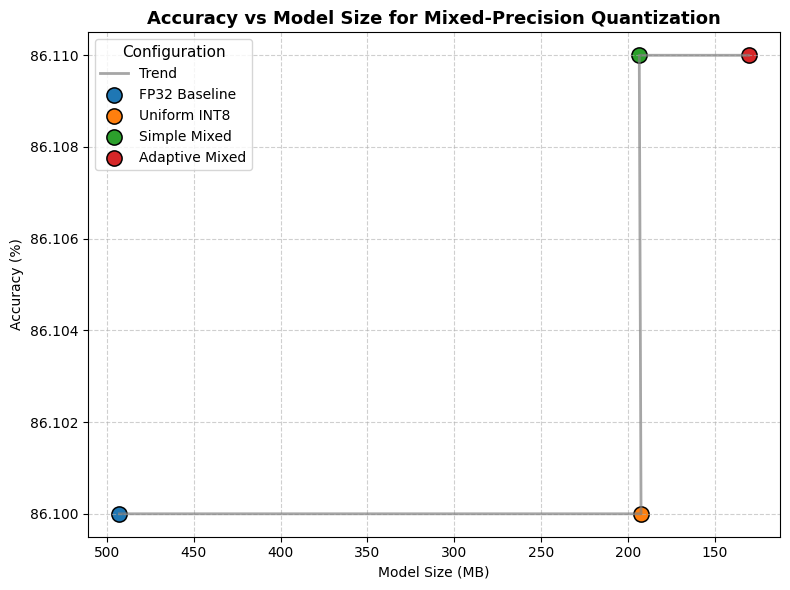

In [ ]:
import matplotlib.pyplot as plt

configs = ["FP32 Baseline", "Uniform INT8", "Simple Mixed", "Adaptive Mixed"]
accuracy = [86.10, 86.10, 86.11, 86.11]
model_size = [492.77, 192.50, 193.53, 130.63]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8, 6))
plt.plot(model_size, accuracy, '-', color='gray', alpha=0.7, linewidth=2, markersize=7, label="Trend")

for i, cfg in enumerate(configs):
    plt.scatter(model_size[i], accuracy[i], s=120, color=colors[i], edgecolors='black', linewidths=1.1, label=cfg)

plt.title("Accuracy vs Model Size for Mixed-Precision Quantization", fontsize=13, weight='bold')
plt.xlabel("Model Size (MB)", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Configuration", fontsize=10, title_fontsize=11, loc="upper left", frameon=True)
plt.tight_layout()

plt.gca().invert_xaxis()

plt.show()

